****Neural Network on Merged Data Minimizing Mean Absolute Percentage Error (MAPE)****

In [1]:
#Author: Bryant
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import random
import statsmodels.api as sma
from statsmodels.stats.outliers_influence import variance_inflation_factor
import keras_tuner as kt

In [2]:
random.seed(12345)

In [3]:
# Importing Data
toyota = pd.read_csv('Merged_Data_with_lag_Lead_Sales.csv', header=0)
toyota.head(20)

,Week,Model,Sales,Region,Website_Visits.Organic.BAT,Website_Visits.Paid.BAT,CTA1.Organic.BAT,CTA1.Paid.BAT,CTA2.Organic.BAT,CTA2.Paid.BAT,...,Impressions.Unknown_Platform.Video,Impressions.NA.Video,Qualified_Actions.Connected_TV.Video,Qualified_Actions.Desktop.Video,Qualified_Actions.Mobile.Video,Qualified_Actions.Unknown_Platform.Video,Qualified_Actions.NA.Video,Week_of_Month,Month_Number,Fin_Year_End
0,2020-10-04,AF,81,Region 1,365,283,343,164,37,6,...,4544,0,0,3792,3184,0,0,1,10,0
1,2020-10-11,AF,84,Region 1,311,303,267,160,5,7,...,2379,0,0,4941,3688,0,0,2,10,0
2,2020-10-18,AF,86,Region 1,165,353,102,297,7,8,...,1405,0,0,5874,4041,0,0,3,10,0
3,2020-10-25,AF,101,Region 1,84,343,73,296,2,11,...,233,0,0,5833,3301,0,0,4,10,0
4,2020-11-01,AF,79,Region 1,89,325,88,295,1,9,...,38,0,0,4671,2645,0,0,1,11,0
5,2020-11-08,AF,68,Region 1,105,321,114,285,5,8,...,150,0,0,5312,3314,0,0,2,11,0
6,2020-11-15,AF,79,Region 1,112,331,108,341,5,11,...,151,0,0,5242,3166,0,0,3,11,0
7,2020-11-22,AF,74,Region 1,84,375,58,297,7,14,...,11,0,0,4272,3209,0,0,4,11,0
8,2020-11-29,AF,81,Region 1,76,280,58,257,5,5,...,1554,0,0,4576,2625,0,0,5,11,0
9,2020-12-06,AF,59,Region 1,69,313,69,263,5,11,...,39969,0,0,4571,3052,0,0,1,12,0


In [4]:
toyota = toyota[toyota.Region != 'Region 13']

In [5]:
toyota.shape

(1500, 99)

In [6]:
covidcars = pd.read_csv('covid_sp_carz.csv', header=0)

In [7]:
covidcars.shape

(39, 23)

In [8]:
covidcars = covidcars.drop('Unnamed: 1',axis=1)
covidcars = covidcars.drop('SP_Date',axis=1)
covidcars = covidcars.drop('Carz_Date',axis=1)

In [9]:
covidcars.shape

(39, 20)

In [10]:
toyota.index = pd.to_datetime(toyota['Week'])
toyota = toyota.drop(['Week'], axis= 1)

In [11]:
covidcars.index = pd.to_datetime(covidcars['date'])
covidcars = covidcars.drop(['date'], axis= 1)

In [12]:
toyota

,Model,Sales,Region,Website_Visits.Organic.BAT,Website_Visits.Paid.BAT,CTA1.Organic.BAT,CTA1.Paid.BAT,CTA2.Organic.BAT,CTA2.Paid.BAT,Website_Visits.Organic.TCOM,...,Impressions.Unknown_Platform.Video,Impressions.NA.Video,Qualified_Actions.Connected_TV.Video,Qualified_Actions.Desktop.Video,Qualified_Actions.Mobile.Video,Qualified_Actions.Unknown_Platform.Video,Qualified_Actions.NA.Video,Week_of_Month,Month_Number,Fin_Year_End
Week,,,,,,,,,,,,,,,,,,,,,
2020-10-04,AF,81,Region 1,365,283,343,164,37,6,1022,...,4544,0,0,3792,3184,0,0,1,10,0
2020-10-11,AF,84,Region 1,311,303,267,160,5,7,1017,...,2379,0,0,4941,3688,0,0,2,10,0
2020-10-18,AF,86,Region 1,165,353,102,297,7,8,1022,...,1405,0,0,5874,4041,0,0,3,10,0
2020-10-25,AF,101,Region 1,84,343,73,296,2,11,902,...,233,0,0,5833,3301,0,0,4,10,0
2020-11-01,AF,79,Region 1,89,325,88,295,1,9,1049,...,38,0,0,4671,2645,0,0,1,11,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-21,AW,116,Region 9,52,124,43,110,1,4,4854,...,124,0,0,518,394,0,0,3,2,0
2021-02-28,AW,141,Region 9,46,105,53,114,1,1,4072,...,97,0,0,579,550,0,0,4,2,0
2021-03-07,AW,151,Region 9,43,96,46,85,0,2,3771,...,75,0,0,451,504,0,0,1,3,1


In [13]:
covidcars

,location,total_cases,new_cases,total_deaths,new_deaths,positive_rate,total_vaccinations,people_fully_vaccinated,new_vaccinations,SP_Open,SP_High,SP_Low,SP_Close,Carz_Open,Carz_High,Carz_Low,Carz_Close,US_Monthly_Employment_Level,US_Avg_Weekly_Employment_Level
date,,,,,,,,,,,,,,,,,,,
2020-10-04,United States,7420413,267696,209987,4583,0.045,NaN,NaN,NaN,3333.90,3397.18,3323.69,3348.44,39.330002,39.490002,38.549999,39.290001,149.70,34.070
2020-10-11,United States,7772051,351638,215157,5170,0.044,NaN,NaN,NaN,3367.27,3482.34,3354.54,3477.13,39.860001,40.820000,39.689999,40.759998,149.70,33.803
2020-10-18,United States,8165987,393936,220380,5223,0.053,NaN,NaN,NaN,3500.02,3549.85,3440.89,3483.81,40.759998,41.200001,39.730000,40.599998,149.70,33.803
2020-10-25,United States,8662175,496188,226182,5802,0.057,NaN,NaN,NaN,3493.66,3502.42,3415.34,3465.39,40.389999,41.750000,40.330002,41.459999,149.70,33.803
2020-11-01,United States,9270686,608511,232209,6027,0.067,NaN,NaN,NaN,3441.42,3441.42,3233.94,3269.96,40.869999,41.209999,39.020000,39.349998,149.81,33.964
2020-11-08,United States,10087716,817030,239518,7309,0.080,NaN,NaN,NaN,3296.20,3529.05,3279.74,3509.44,40.509998,44.000000,40.509998,43.660000,149.81,34.930
2020-11-15,United States,11144834,1057118,247684,8166,0.099,NaN,NaN,NaN,3583.04,3645.99,3511.91,3585.15,45.860001,46.930000,44.570000,45.930000,149.81,34.930
2020-11-22,United States,12360893,1216059,258826,11142,0.095,NaN,NaN,NaN,3600.16,3628.51,3543.84,3557.54,46.570000,48.470001,46.570000,48.410000,149.81,34.930
2020-11-29,United States,13510377,1149484,269658,10832,0.101,NaN,NaN,NaN,3566.82,3644.31,3552.77,3638.35,48.990002,50.680000,48.990002,49.400002,149.81,34.930


In [14]:
toyota = pd.merge(toyota,covidcars, how='inner', left_index=True, right_index=True)

In [15]:
# Selecting predictor variables
col_list = ['Sales','Model','Region','CTA2.Paid.BAT','Website_Visits.Paid.TCOM','CTA1.Organic.TCOM','CTA1.Paid.TCOM','CTA2.Organic.TCOM','CTA2.Paid.TCOM',
            'Lead_Sales.Category_7','Lead_Sales.Category_5','Lead_Sales.Category_6','Lead_Sales.Category_4','Lead_Sales.Category_9','Lead_Sales.Category_7_lag2',
            'Lead_Sales.Category_5_lag1','Lead_Sales.Category_5_lag3','Lead_Sales.Category_4_lag2','Lead_Sales.Category_4_lag3','Lead_Sales.Category_4_lag4',
            'Lead_Sales.Category_9_lag1','Lead_Sales.Category_9_lag2','Impressions.Connected_TV.Display','Qualified_Actions.Desktop.Display','Qualified_Actions.Mobile.Display',
            'Qualified_Actions.NA.Search','Qualified_Actions.NA.Social','Impressions.Connected_TV.Video','Impressions.Unknown_Platform.Video','Qualified_Actions.Mobile.Video',
            'Week_of_Month','new_cases','new_deaths','people_fully_vaccinated','SP_Open','SP_Low','SP_Close']

In [16]:
toyota = toyota[col_list]

In [17]:
toyota.shape

(1500, 37)

In [18]:
# Variance Inflation Factor (VIF)
def vif_arr(df):
    vif = pd.DataFrame()
    df=sma.add_constant(df)
    vif['variables'] = df.columns
    vif['VIF'] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    
    return(vif)

In [19]:
# Dummy Variables for Model
dummies_model = pd.get_dummies(toyota.Model)
dummies_model

,AF,AH,AL,AR,AW
2020-10-04,1,0,0,0,0
2020-10-04,1,0,0,0,0
2020-10-04,1,0,0,0,0
2020-10-04,1,0,0,0,0
2020-10-04,1,0,0,0,0
...,...,...,...,...,...
2021-03-21,0,0,0,0,1
2021-03-21,0,0,0,0,1
2021-03-21,0,0,0,0,1
2021-03-21,0,0,0,0,1


In [20]:
# Dummy Variables for Region (1-12, removing Region 13)
dummies_region = pd.get_dummies(toyota.Region)
dummies_region

,Region 1,Region 10,Region 11,Region 12,Region 2,Region 3,Region 4,Region 5,Region 6,Region 7,Region 8,Region 9
2020-10-04,1,0,0,0,0,0,0,0,0,0,0,0
2020-10-04,0,1,0,0,0,0,0,0,0,0,0,0
2020-10-04,0,0,1,0,0,0,0,0,0,0,0,0
2020-10-04,0,0,0,1,0,0,0,0,0,0,0,0
2020-10-04,0,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-21,0,0,0,0,0,0,0,1,0,0,0,0
2021-03-21,0,0,0,0,0,0,0,0,1,0,0,0
2021-03-21,0,0,0,0,0,0,0,0,0,1,0,0
2021-03-21,0,0,0,0,0,0,0,0,0,0,1,0


In [21]:
# Dummy Variables for Week_of_Month (1-5)
dummies_Week_of_Month = pd.get_dummies(toyota, columns=['Week_of_Month'])
dummies_Week_of_Month = dummies_Week_of_Month.loc[:,'Week_of_Month_1':'Week_of_Month_5']
dummies_Week_of_Month

,Week_of_Month_1,Week_of_Month_2,Week_of_Month_3,Week_of_Month_4,Week_of_Month_5
2020-10-04,1,0,0,0,0
2020-10-04,1,0,0,0,0
2020-10-04,1,0,0,0,0
2020-10-04,1,0,0,0,0
2020-10-04,1,0,0,0,0
...,...,...,...,...,...
2021-03-21,0,0,1,0,0
2021-03-21,0,0,1,0,0
2021-03-21,0,0,1,0,0
2021-03-21,0,0,1,0,0


In [22]:
# # Dummy Variables for Fin_Year_End (1-12)
# dummies_Fin_Year_End = pd.get_dummies(toyota, columns=['Fin_Year_End'])
# dummies_Fin_Year_End = dummies_Fin_Year_End.loc[:,'Fin_Year_End_0':'Fin_Year_End_1']
# dummies_Fin_Year_End

In [23]:
# Replacing old categorical features with dummy variables
newtoyota = pd.concat([toyota,dummies_model,dummies_region,dummies_Week_of_Month],axis='columns')

del newtoyota['Model']
del newtoyota['Region']
del newtoyota['Week_of_Month']
#del newtoyota['Month_Number']
# del newtoyota['Fin_Year_End']

In [24]:
# Filling NA values
newtoyota = newtoyota.fillna(0)

In [25]:
# Checks for empty columns and removes them
newtoyota=newtoyota.loc[:, (newtoyota.sum(axis=0) != 0)]

In [26]:
newtoyota.shape

(1500, 56)

In [27]:
newtoyota.head()

,Sales,CTA2.Paid.BAT,Website_Visits.Paid.TCOM,CTA1.Organic.TCOM,CTA1.Paid.TCOM,CTA2.Organic.TCOM,CTA2.Paid.TCOM,Lead_Sales.Category_7,Lead_Sales.Category_5,Lead_Sales.Category_6,...,Region 5,Region 6,Region 7,Region 8,Region 9,Week_of_Month_1,Week_of_Month_2,Week_of_Month_3,Week_of_Month_4,Week_of_Month_5
2020-10-04,81,6,971,512,399,83,70,0,2,0,...,0,0,0,0,0,1,0,0,0,0
2020-10-04,61,1,998,488,349,69,55,3,4,0,...,0,0,0,0,0,1,0,0,0,0
2020-10-04,159,2,2187,975,768,171,153,1,0,0,...,0,0,0,0,0,1,0,0,0,0
2020-10-04,676,0,4077,2073,1471,51,42,10,4,0,...,0,0,0,0,0,1,0,0,0,0
2020-10-04,215,10,2797,1259,1034,177,141,2,4,1,...,0,0,0,0,0,1,0,0,0,0


In [28]:
newtoyota.columns

Index(['Sales', 'CTA2.Paid.BAT', 'Website_Visits.Paid.TCOM',
       'CTA1.Organic.TCOM', 'CTA1.Paid.TCOM', 'CTA2.Organic.TCOM',
       'CTA2.Paid.TCOM', 'Lead_Sales.Category_7', 'Lead_Sales.Category_5',
       'Lead_Sales.Category_6', 'Lead_Sales.Category_4',
       'Lead_Sales.Category_9', 'Lead_Sales.Category_7_lag2',
       'Lead_Sales.Category_5_lag1', 'Lead_Sales.Category_5_lag3',
       'Lead_Sales.Category_4_lag2', 'Lead_Sales.Category_4_lag3',
       'Lead_Sales.Category_4_lag4', 'Lead_Sales.Category_9_lag1',
       'Lead_Sales.Category_9_lag2', 'Impressions.Connected_TV.Display',
       'Qualified_Actions.Desktop.Display', 'Qualified_Actions.Mobile.Display',
       'Qualified_Actions.NA.Search', 'Qualified_Actions.NA.Social',
       'Impressions.Connected_TV.Video', 'Impressions.Unknown_Platform.Video',
       'Qualified_Actions.Mobile.Video', 'new_cases', 'new_deaths',
       'people_fully_vaccinated', 'SP_Open', 'SP_Low', 'SP_Close', 'AF', 'AH',
       'AL', 'AR', 'AW', 'Reg

In [29]:
# # Checking Data Types, must change objects to numeric
# print(newtoyota.loc[:,'positive_rate':'SP_Close'].dtypes)

In [30]:
newtoyota.columns

Index(['Sales', 'CTA2.Paid.BAT', 'Website_Visits.Paid.TCOM',
       'CTA1.Organic.TCOM', 'CTA1.Paid.TCOM', 'CTA2.Organic.TCOM',
       'CTA2.Paid.TCOM', 'Lead_Sales.Category_7', 'Lead_Sales.Category_5',
       'Lead_Sales.Category_6', 'Lead_Sales.Category_4',
       'Lead_Sales.Category_9', 'Lead_Sales.Category_7_lag2',
       'Lead_Sales.Category_5_lag1', 'Lead_Sales.Category_5_lag3',
       'Lead_Sales.Category_4_lag2', 'Lead_Sales.Category_4_lag3',
       'Lead_Sales.Category_4_lag4', 'Lead_Sales.Category_9_lag1',
       'Lead_Sales.Category_9_lag2', 'Impressions.Connected_TV.Display',
       'Qualified_Actions.Desktop.Display', 'Qualified_Actions.Mobile.Display',
       'Qualified_Actions.NA.Search', 'Qualified_Actions.NA.Social',
       'Impressions.Connected_TV.Video', 'Impressions.Unknown_Platform.Video',
       'Qualified_Actions.Mobile.Video', 'new_cases', 'new_deaths',
       'people_fully_vaccinated', 'SP_Open', 'SP_Low', 'SP_Close', 'AF', 'AH',
       'AL', 'AR', 'AW', 'Reg

In [31]:
train = newtoyota 

In [32]:
# Importing Data
val_set = pd.read_csv('Validation_Merged_Data_with_lag_Lead_Sales.csv', header=0)
val_set.head(20)

val_set = val_set[val_set.Region != 'Region 13']

# Selecting predictor variables for Test Set (No Sales)
col_listtest = ['Model','Region','CTA2.Paid.BAT','Website_Visits.Paid.TCOM','CTA1.Organic.TCOM','CTA1.Paid.TCOM','CTA2.Organic.TCOM','CTA2.Paid.TCOM',
            'Lead_Sales.Category_7','Lead_Sales.Category_5','Lead_Sales.Category_6','Lead_Sales.Category_4','Lead_Sales.Category_9','Lead_Sales.Category_7_lag2',
            'Lead_Sales.Category_5_lag1','Lead_Sales.Category_5_lag3','Lead_Sales.Category_4_lag2','Lead_Sales.Category_4_lag3','Lead_Sales.Category_4_lag4',
            'Lead_Sales.Category_9_lag1','Lead_Sales.Category_9_lag2','Impressions.Connected_TV.Display','Qualified_Actions.Desktop.Display','Qualified_Actions.Mobile.Display',
            'Qualified_Actions.NA.Search','Qualified_Actions.NA.Social','Impressions.Connected_TV.Video','Impressions.Unknown_Platform.Video','Qualified_Actions.Mobile.Video',
            'Week_of_Month','new_cases','new_deaths','people_fully_vaccinated','SP_Open','SP_Low','SP_Close']

val_set.index = pd.to_datetime(val_set['Week'])
val_set = val_set.drop(['Week'], axis= 1)
val_set = pd.merge(val_set,covidcars, how='inner', left_index=True, right_index=True)
val_set  = val_set[col_listtest]

# Dummy Variables for Model
dummies_modeltest = pd.get_dummies(val_set.Model)
dummies_modeltest
# Dummy Variables for Region (1-12, removing Region 13)
dummies_regiontest = pd.get_dummies(val_set.Region)
dummies_regiontest
# Dummy Variables for Week_of_Month (1-5)
dummies_Week_of_Monthtest = pd.get_dummies(val_set, columns=['Week_of_Month'])
dummies_Week_of_Monthtest = dummies_Week_of_Monthtest.loc[:,'Week_of_Month_1':'Week_of_Month_5']
dummies_Week_of_Monthtest
# Dummy Variables for Fin_Year_End (1-12)
# dummies_Fin_Year_Endtest = pd.get_dummies(val_set, columns=['Fin_Year_End'])
# dummies_Fin_Year_Endtest = dummies_Fin_Year_Endtest.loc[:,'Fin_Year_End_0':'Fin_Year_End_1']
# dummies_Fin_Year_Endtest


# Replacing old categorical features with dummy variables
test = pd.concat([val_set,dummies_modeltest,dummies_regiontest,dummies_Week_of_Monthtest],axis='columns')

del test['Model']
del test['Region']
del test['Week_of_Month']
# del test['Fin_Year_End']
# Filling NA values
test = test.fillna(0)

# Checks for empty columns and removes them
test=test.loc[:, (test.sum(axis=0) != 0)]

test.head()

,CTA2.Paid.BAT,Website_Visits.Paid.TCOM,CTA1.Organic.TCOM,CTA1.Paid.TCOM,CTA2.Organic.TCOM,CTA2.Paid.TCOM,Lead_Sales.Category_7,Lead_Sales.Category_5,Lead_Sales.Category_6,Lead_Sales.Category_4,...,Region 5,Region 6,Region 7,Region 8,Region 9,Week_of_Month_1,Week_of_Month_2,Week_of_Month_3,Week_of_Month_4,Week_of_Month_5
2020-10-04,6,971,512,399,83,70,0,2,0,0,...,0,0,0,0,0,1,0,0,0,0
2020-10-04,1,998,488,349,69,55,3,4,0,0,...,0,0,0,0,0,1,0,0,0,0
2020-10-04,2,2187,975,768,171,153,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2020-10-04,0,4077,2073,1471,51,42,10,4,0,0,...,0,0,0,0,0,1,0,0,0,0
2020-10-04,10,2797,1259,1034,177,141,2,4,1,0,...,0,0,0,0,0,1,0,0,0,0


In [33]:
test.shape

(2220, 55)

In [34]:
train.shape

(1500, 56)

In [35]:
train.columns

Index(['Sales', 'CTA2.Paid.BAT', 'Website_Visits.Paid.TCOM',
       'CTA1.Organic.TCOM', 'CTA1.Paid.TCOM', 'CTA2.Organic.TCOM',
       'CTA2.Paid.TCOM', 'Lead_Sales.Category_7', 'Lead_Sales.Category_5',
       'Lead_Sales.Category_6', 'Lead_Sales.Category_4',
       'Lead_Sales.Category_9', 'Lead_Sales.Category_7_lag2',
       'Lead_Sales.Category_5_lag1', 'Lead_Sales.Category_5_lag3',
       'Lead_Sales.Category_4_lag2', 'Lead_Sales.Category_4_lag3',
       'Lead_Sales.Category_4_lag4', 'Lead_Sales.Category_9_lag1',
       'Lead_Sales.Category_9_lag2', 'Impressions.Connected_TV.Display',
       'Qualified_Actions.Desktop.Display', 'Qualified_Actions.Mobile.Display',
       'Qualified_Actions.NA.Search', 'Qualified_Actions.NA.Social',
       'Impressions.Connected_TV.Video', 'Impressions.Unknown_Platform.Video',
       'Qualified_Actions.Mobile.Video', 'new_cases', 'new_deaths',
       'people_fully_vaccinated', 'SP_Open', 'SP_Low', 'SP_Close', 'AF', 'AH',
       'AL', 'AR', 'AW', 'Reg

In [36]:
test.columns

Index(['CTA2.Paid.BAT', 'Website_Visits.Paid.TCOM', 'CTA1.Organic.TCOM',
       'CTA1.Paid.TCOM', 'CTA2.Organic.TCOM', 'CTA2.Paid.TCOM',
       'Lead_Sales.Category_7', 'Lead_Sales.Category_5',
       'Lead_Sales.Category_6', 'Lead_Sales.Category_4',
       'Lead_Sales.Category_9', 'Lead_Sales.Category_7_lag2',
       'Lead_Sales.Category_5_lag1', 'Lead_Sales.Category_5_lag3',
       'Lead_Sales.Category_4_lag2', 'Lead_Sales.Category_4_lag3',
       'Lead_Sales.Category_4_lag4', 'Lead_Sales.Category_9_lag1',
       'Lead_Sales.Category_9_lag2', 'Impressions.Connected_TV.Display',
       'Qualified_Actions.Desktop.Display', 'Qualified_Actions.Mobile.Display',
       'Qualified_Actions.NA.Search', 'Qualified_Actions.NA.Social',
       'Impressions.Connected_TV.Video', 'Impressions.Unknown_Platform.Video',
       'Qualified_Actions.Mobile.Video', 'new_cases', 'new_deaths',
       'people_fully_vaccinated', 'SP_Open', 'SP_Low', 'SP_Close', 'AF', 'AH',
       'AL', 'AR', 'AW', 'Region 1', '

In [37]:
# Correlation Matrix for Continuous Variables
correlation_matrix = train.loc[:,'Sales':'SP_Close'].corr()
correlation_matrix

,Sales,CTA2.Paid.BAT,Website_Visits.Paid.TCOM,CTA1.Organic.TCOM,CTA1.Paid.TCOM,CTA2.Organic.TCOM,CTA2.Paid.TCOM,Lead_Sales.Category_7,Lead_Sales.Category_5,Lead_Sales.Category_6,...,Qualified_Actions.NA.Social,Impressions.Connected_TV.Video,Impressions.Unknown_Platform.Video,Qualified_Actions.Mobile.Video,new_cases,new_deaths,people_fully_vaccinated,SP_Open,SP_Low,SP_Close
Sales,1.000000,0.073784,0.636143,0.324973,0.196112,0.185930,0.212781,0.263924,0.195610,-0.042842,...,-0.053917,0.065777,-0.021108,0.107000,-0.067208,-0.092774,0.106926,0.037598,0.043419,0.034464
CTA2.Paid.BAT,0.073784,1.000000,0.066531,0.036083,-0.032747,0.284981,0.296724,-0.162136,0.141696,0.079026,...,0.039772,0.091724,0.000916,0.105983,-0.033665,-0.079384,0.000123,-0.051133,-0.046783,-0.041580
Website_Visits.Paid.TCOM,0.636143,0.066531,1.000000,0.604411,0.565030,0.538575,0.590593,0.420351,0.258433,0.168477,...,0.211380,-0.010937,-0.055315,-0.021263,-0.051519,0.068180,0.182553,0.172496,0.193206,0.212678
CTA1.Organic.TCOM,0.324973,0.036083,0.604411,1.000000,0.406931,0.582078,0.542368,0.482942,0.284947,0.264360,...,0.331646,-0.012648,-0.084272,-0.095458,0.109046,0.127402,-0.024447,0.073379,0.082702,0.085191
CTA1.Paid.TCOM,0.196112,-0.032747,0.565030,0.406931,1.000000,0.363454,0.400494,0.480008,0.274080,0.252844,...,0.221624,0.070244,-0.016952,-0.059120,-0.100740,-0.185305,0.138486,-0.051932,-0.052652,-0.020001
CTA2.Organic.TCOM,0.185930,0.284981,0.538575,0.582078,0.363454,1.000000,0.958494,0.280467,0.130199,0.415503,...,0.273980,0.075383,-0.054309,-0.056198,0.003783,-0.041489,0.017219,-0.020315,-0.014114,0.000417
CTA2.Paid.TCOM,0.212781,0.296724,0.590593,0.542368,0.400494,0.958494,1.000000,0.281415,0.136967,0.410542,...,0.275897,0.129253,-0.025991,-0.019686,-0.009317,-0.083207,0.041815,-0.037761,-0.018570,0.001971
Lead_Sales.Category_7,0.263924,-0.162136,0.420351,0.482942,0.480008,0.280467,0.281415,1.000000,0.517726,0.344885,...,0.233732,0.063441,-0.064859,-0.088958,0.010692,-0.050308,0.019282,-0.025719,-0.013188,0.002298
Lead_Sales.Category_5,0.195610,0.141696,0.258433,0.284947,0.274080,0.130199,0.136967,0.517726,1.000000,0.299211,...,0.164645,0.055162,-0.044904,-0.033616,0.016896,0.010058,0.078375,0.055639,0.065251,0.073754
Lead_Sales.Category_6,-0.042842,0.079026,0.168477,0.264360,0.252844,0.415503,0.410542,0.344885,0.299211,1.000000,...,0.121113,0.060938,-0.044558,-0.073761,-0.028704,-0.040479,0.031345,-0.004089,-0.003458,-0.000285


In [38]:
abscorr = correlation_matrix.iloc[correlation_matrix.Sales.abs().argsort()]

In [39]:
abscorr.sort_values('Sales', ascending=False, axis=0)

,Sales,CTA2.Paid.BAT,Website_Visits.Paid.TCOM,CTA1.Organic.TCOM,CTA1.Paid.TCOM,CTA2.Organic.TCOM,CTA2.Paid.TCOM,Lead_Sales.Category_7,Lead_Sales.Category_5,Lead_Sales.Category_6,...,Qualified_Actions.NA.Social,Impressions.Connected_TV.Video,Impressions.Unknown_Platform.Video,Qualified_Actions.Mobile.Video,new_cases,new_deaths,people_fully_vaccinated,SP_Open,SP_Low,SP_Close
Sales,1.000000,0.073784,0.636143,0.324973,0.196112,0.185930,0.212781,0.263924,0.195610,-0.042842,...,-0.053917,0.065777,-0.021108,0.107000,-0.067208,-0.092774,0.106926,0.037598,0.043419,0.034464
Website_Visits.Paid.TCOM,0.636143,0.066531,1.000000,0.604411,0.565030,0.538575,0.590593,0.420351,0.258433,0.168477,...,0.211380,-0.010937,-0.055315,-0.021263,-0.051519,0.068180,0.182553,0.172496,0.193206,0.212678
CTA1.Organic.TCOM,0.324973,0.036083,0.604411,1.000000,0.406931,0.582078,0.542368,0.482942,0.284947,0.264360,...,0.331646,-0.012648,-0.084272,-0.095458,0.109046,0.127402,-0.024447,0.073379,0.082702,0.085191
Qualified_Actions.NA.Search,0.302306,0.242254,0.604016,0.292109,0.310292,0.372428,0.464249,0.315870,0.366653,0.262112,...,-0.009766,-0.016962,-0.069708,-0.089106,-0.079091,0.080322,0.274167,0.251477,0.257621,0.272981
Lead_Sales.Category_7,0.263924,-0.162136,0.420351,0.482942,0.480008,0.280467,0.281415,1.000000,0.517726,0.344885,...,0.233732,0.063441,-0.064859,-0.088958,0.010692,-0.050308,0.019282,-0.025719,-0.013188,0.002298
Lead_Sales.Category_7_lag2,0.231838,-0.164441,0.386762,0.449838,0.387583,0.249992,0.239568,0.661337,0.474596,0.293497,...,0.235071,-0.052546,-0.025973,-0.109537,0.193742,0.141573,0.008827,0.131972,0.111586,0.115435
CTA2.Paid.TCOM,0.212781,0.296724,0.590593,0.542368,0.400494,0.958494,1.000000,0.281415,0.136967,0.410542,...,0.275897,0.129253,-0.025991,-0.019686,-0.009317,-0.083207,0.041815,-0.037761,-0.018570,0.001971
Qualified_Actions.Desktop.Display,0.203819,0.137409,0.150340,-0.087123,0.035855,0.004417,0.047181,-0.038770,0.025142,-0.015601,...,0.006887,0.238471,0.056527,0.615416,-0.114038,-0.255136,-0.007611,-0.197767,-0.193936,-0.182387
CTA1.Paid.TCOM,0.196112,-0.032747,0.565030,0.406931,1.000000,0.363454,0.400494,0.480008,0.274080,0.252844,...,0.221624,0.070244,-0.016952,-0.059120,-0.100740,-0.185305,0.138486,-0.051932,-0.052652,-0.020001
Lead_Sales.Category_5,0.195610,0.141696,0.258433,0.284947,0.274080,0.130199,0.136967,0.517726,1.000000,0.299211,...,0.164645,0.055162,-0.044904,-0.033616,0.016896,0.010058,0.078375,0.055639,0.065251,0.073754


In [40]:
# Correlation for Continuous Variables Sorted by Sales Descending
correlation_matrix.sort_values('Sales', ascending=False, axis=0)

,Sales,CTA2.Paid.BAT,Website_Visits.Paid.TCOM,CTA1.Organic.TCOM,CTA1.Paid.TCOM,CTA2.Organic.TCOM,CTA2.Paid.TCOM,Lead_Sales.Category_7,Lead_Sales.Category_5,Lead_Sales.Category_6,...,Qualified_Actions.NA.Social,Impressions.Connected_TV.Video,Impressions.Unknown_Platform.Video,Qualified_Actions.Mobile.Video,new_cases,new_deaths,people_fully_vaccinated,SP_Open,SP_Low,SP_Close
Sales,1.000000,0.073784,0.636143,0.324973,0.196112,0.185930,0.212781,0.263924,0.195610,-0.042842,...,-0.053917,0.065777,-0.021108,0.107000,-0.067208,-0.092774,0.106926,0.037598,0.043419,0.034464
Website_Visits.Paid.TCOM,0.636143,0.066531,1.000000,0.604411,0.565030,0.538575,0.590593,0.420351,0.258433,0.168477,...,0.211380,-0.010937,-0.055315,-0.021263,-0.051519,0.068180,0.182553,0.172496,0.193206,0.212678
CTA1.Organic.TCOM,0.324973,0.036083,0.604411,1.000000,0.406931,0.582078,0.542368,0.482942,0.284947,0.264360,...,0.331646,-0.012648,-0.084272,-0.095458,0.109046,0.127402,-0.024447,0.073379,0.082702,0.085191
Qualified_Actions.NA.Search,0.302306,0.242254,0.604016,0.292109,0.310292,0.372428,0.464249,0.315870,0.366653,0.262112,...,-0.009766,-0.016962,-0.069708,-0.089106,-0.079091,0.080322,0.274167,0.251477,0.257621,0.272981
Lead_Sales.Category_7,0.263924,-0.162136,0.420351,0.482942,0.480008,0.280467,0.281415,1.000000,0.517726,0.344885,...,0.233732,0.063441,-0.064859,-0.088958,0.010692,-0.050308,0.019282,-0.025719,-0.013188,0.002298
Lead_Sales.Category_7_lag2,0.231838,-0.164441,0.386762,0.449838,0.387583,0.249992,0.239568,0.661337,0.474596,0.293497,...,0.235071,-0.052546,-0.025973,-0.109537,0.193742,0.141573,0.008827,0.131972,0.111586,0.115435
CTA2.Paid.TCOM,0.212781,0.296724,0.590593,0.542368,0.400494,0.958494,1.000000,0.281415,0.136967,0.410542,...,0.275897,0.129253,-0.025991,-0.019686,-0.009317,-0.083207,0.041815,-0.037761,-0.018570,0.001971
Qualified_Actions.Desktop.Display,0.203819,0.137409,0.150340,-0.087123,0.035855,0.004417,0.047181,-0.038770,0.025142,-0.015601,...,0.006887,0.238471,0.056527,0.615416,-0.114038,-0.255136,-0.007611,-0.197767,-0.193936,-0.182387
CTA1.Paid.TCOM,0.196112,-0.032747,0.565030,0.406931,1.000000,0.363454,0.400494,0.480008,0.274080,0.252844,...,0.221624,0.070244,-0.016952,-0.059120,-0.100740,-0.185305,0.138486,-0.051932,-0.052652,-0.020001
Lead_Sales.Category_5,0.195610,0.141696,0.258433,0.284947,0.274080,0.130199,0.136967,0.517726,1.000000,0.299211,...,0.164645,0.055162,-0.044904,-0.033616,0.016896,0.010058,0.078375,0.055639,0.065251,0.073754


In [41]:
# Pairplots
# sns.pairplot(train[['Sales', 'Qualified_Actions.Mobile.Display', 'Qualified_Actions.NA.Social', 'Lead_Sales.Category_7_lag1', 'Lead_Sales.Category_5', 'CTA2.Paid.BAT', 
#             'Impressions.Connected_TV.Video', 'Impressions.Mobile.Video', 'Impressions.Connected_TV.Display', 'Lead_Sales.Category_5_lag4', 'Lead_Sales.Category_7_lag2', 
#             'Lead_Sales.Category_7', 'Website_Visits.Paid.BAT','Website_Visits.Organic.BAT','Lead_Sales.Category_5_lag1','Qualified_Actions.Mobile.Video', 
#             'Impressions.Desktop.Display', 'Impressions.Mobile.Display', 'Impressions.NA.Search', 'Impressions.Unknown_Platform.Video', 'Lead_Sales.Category_7_lag4', 
#             'Lead_Sales.Category_8_lag1', 'Lead_Sales.Category_9', 'Lead_Sales.Category_9_lag4']], diag_kind='kde')

In [42]:
# Statistics of Training Data
trainstat = train.describe()
trainstat.pop('Sales')
trainstat = trainstat.transpose()
trainstat = trainstat.loc['CTA2.Paid.BAT':'SP_Close',:]

In [43]:
# Response Variable
trainlabel = train.pop('Sales')
#testlabel = test.pop('Sales')

In [44]:
# Normalization
def normalize(x):
    return(x- trainstat['mean']) / trainstat['std']
norm_train = normalize(train.loc[:,'CTA2.Paid.BAT':'SP_Close'])
norm_test = normalize(test.loc[:,'CTA2.Paid.BAT':'SP_Close'])

In [81]:
norm_test

,CTA2.Paid.BAT,Website_Visits.Paid.TCOM,CTA1.Organic.TCOM,CTA1.Paid.TCOM,CTA2.Organic.TCOM,CTA2.Paid.TCOM,Lead_Sales.Category_7,Lead_Sales.Category_5,Lead_Sales.Category_6,Lead_Sales.Category_4,...,Region 5,Region 6,Region 7,Region 8,Region 9,Week_of_Month_1,Week_of_Month_2,Week_of_Month_3,Week_of_Month_4,Week_of_Month_5
2020-10-04,0.113106,-1.092301,-0.860109,-0.708414,-0.702060,-0.560676,-1.172922,-0.358037,-0.723987,-0.280511,...,0,0,0,0,0,1,0,0,0,0
2020-10-04,-0.734345,-1.070692,-0.882747,-0.759614,-0.814423,-0.716689,-0.286732,0.547621,-0.723987,-0.280511,...,0,0,0,0,0,1,0,0,0,0
2020-10-04,-0.564854,-0.119077,-0.423376,-0.330563,0.004222,0.302596,-0.877525,-1.263694,-0.723987,-0.280511,...,0,0,0,0,0,1,0,0,0,0
2020-10-04,-0.903835,1.393582,0.612330,0.389301,-0.958890,-0.851900,1.781045,0.547621,-0.723987,-0.280511,...,0,0,0,0,0,1,0,0,0,0
2020-10-04,0.791067,0.369136,-0.155489,-0.058182,0.052377,0.177785,-0.582128,0.547621,0.231141,-0.280511,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-13,-0.734345,0.404351,0.840601,1.158317,3.952979,3.162833,-0.582128,-1.263694,-0.723987,-0.280511,...,1,0,0,0,0,0,1,0,0,0
2021-06-13,1.469028,0.559619,2.346053,0.456885,-0.694034,2.757199,-1.172922,-1.263694,-0.723987,-0.280511,...,0,1,0,0,0,0,1,0,0,0
2021-06-13,-0.903835,-0.832988,-0.369610,-0.590656,1.079696,-0.155042,0.304062,-0.810866,-0.723987,-0.280511,...,0,0,1,0,0,0,1,0,0,0
2021-06-13,-0.056384,0.305108,2.379068,0.251063,6.023669,3.953298,-0.286732,-0.810866,2.141397,-0.280511,...,0,0,0,1,0,0,1,0,0,0


In [45]:
trainlabel

2020-10-04     81
2020-10-04     61
2020-10-04    159
2020-10-04    676
2020-10-04    215
             ... 
2021-03-21    313
2021-03-21    344
2021-03-21     86
2021-03-21    311
2021-03-21    136
Name: Sales, Length: 1500, dtype: int64

In [46]:
norm_train.head(5)

,CTA2.Paid.BAT,Website_Visits.Paid.TCOM,CTA1.Organic.TCOM,CTA1.Paid.TCOM,CTA2.Organic.TCOM,CTA2.Paid.TCOM,Lead_Sales.Category_7,Lead_Sales.Category_5,Lead_Sales.Category_6,Lead_Sales.Category_4,...,Qualified_Actions.NA.Social,Impressions.Connected_TV.Video,Impressions.Unknown_Platform.Video,Qualified_Actions.Mobile.Video,new_cases,new_deaths,people_fully_vaccinated,SP_Open,SP_Low,SP_Close
2020-10-04,0.113106,-1.092301,-0.860109,-0.708414,-0.702060,-0.560676,-1.172922,-0.358037,-0.723987,-0.280511,...,0.897241,0.814099,0.37921,1.865904,-1.381011,-1.414912,-0.58194,-1.834756,-1.574097,-1.856704
2020-10-04,-0.734345,-1.070692,-0.882747,-0.759614,-0.814423,-0.716689,-0.286732,0.547621,-0.723987,-0.280511,...,0.897241,0.814099,0.37921,1.865904,-1.381011,-1.414912,-0.58194,-1.834756,-1.574097,-1.856704
2020-10-04,-0.564854,-0.119077,-0.423376,-0.330563,0.004222,0.302596,-0.877525,-1.263694,-0.723987,-0.280511,...,0.897241,0.814099,0.37921,1.865904,-1.381011,-1.414912,-0.58194,-1.834756,-1.574097,-1.856704
2020-10-04,-0.903835,1.393582,0.612330,0.389301,-0.958890,-0.851900,1.781045,0.547621,-0.723987,-0.280511,...,0.897241,0.814099,0.37921,1.865904,-1.381011,-1.414912,-0.58194,-1.834756,-1.574097,-1.856704
2020-10-04,0.791067,0.369136,-0.155489,-0.058182,0.052377,0.177785,-0.582128,0.547621,0.231141,-0.280511,...,0.897241,0.814099,0.37921,1.865904,-1.381011,-1.414912,-0.58194,-1.834756,-1.574097,-1.856704


In [47]:
# Adding the categorical variables back into the training data.
norm_train = pd.concat([norm_train,train.loc[:,'AF':]],axis='columns')
norm_test = pd.concat([norm_test,test.loc[:,'AF':]],axis='columns')

In [48]:
norm_train.head(5)

,CTA2.Paid.BAT,Website_Visits.Paid.TCOM,CTA1.Organic.TCOM,CTA1.Paid.TCOM,CTA2.Organic.TCOM,CTA2.Paid.TCOM,Lead_Sales.Category_7,Lead_Sales.Category_5,Lead_Sales.Category_6,Lead_Sales.Category_4,...,Region 5,Region 6,Region 7,Region 8,Region 9,Week_of_Month_1,Week_of_Month_2,Week_of_Month_3,Week_of_Month_4,Week_of_Month_5
2020-10-04,0.113106,-1.092301,-0.860109,-0.708414,-0.702060,-0.560676,-1.172922,-0.358037,-0.723987,-0.280511,...,0,0,0,0,0,1,0,0,0,0
2020-10-04,-0.734345,-1.070692,-0.882747,-0.759614,-0.814423,-0.716689,-0.286732,0.547621,-0.723987,-0.280511,...,0,0,0,0,0,1,0,0,0,0
2020-10-04,-0.564854,-0.119077,-0.423376,-0.330563,0.004222,0.302596,-0.877525,-1.263694,-0.723987,-0.280511,...,0,0,0,0,0,1,0,0,0,0
2020-10-04,-0.903835,1.393582,0.612330,0.389301,-0.958890,-0.851900,1.781045,0.547621,-0.723987,-0.280511,...,0,0,0,0,0,1,0,0,0,0
2020-10-04,0.791067,0.369136,-0.155489,-0.058182,0.052377,0.177785,-0.582128,0.547621,0.231141,-0.280511,...,0,0,0,0,0,1,0,0,0,0


In [49]:
# Building Neural Network with Hyperparameter Tuning
def buildmodel(hp):
    nn = keras.Sequential()
    for i in range(hp.Int('num_layers', 2, 20)):
        nn.add(layers.Dense(units=hp.Int('units_' + str(i),
                                           min_value=32,
                                           max_value=512,
                                           step=32),
                              activation='relu'))
    nn.add(layers.Dense(1, activation='linear'))
    nn.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate', [1e-2,1e-3,1e-4])),
        loss='mape',
        metrics=['mae', 'mape','mse'])
    return nn

In [50]:
tuner = kt.RandomSearch(buildmodel, objective = 'val_mape', max_trials = 10, executions_per_trial = 3, directory='finaltuning',project_name='last_all5')

In [51]:
# Patience is amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor ='val_loss', patience=10)

In [52]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 20, 'step': 1, 'sampling': None}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [53]:
tuner.search(norm_train, trainlabel, epochs=50, validation_split=0.2, callbacks=[early_stop])

Trial 10 Complete [00h 00m 08s]
val_mape: 23.134830474853516

Best val_mape So Far: 18.768288294474285
Total elapsed time: 00h 02m 13s
INFO:tensorflow:Oracle triggered exit


In [54]:
tuner.results_summary()

Results summary
Results in finaltuning\last_all5
Showing 10 best trials
Objective(name='val_mape', direction='min')
Trial summary
Hyperparameters:
num_layers: 9
units_0: 512
units_1: 416
learning_rate: 0.001
units_2: 64
units_3: 224
units_4: 160
units_5: 384
units_6: 288
units_7: 384
units_8: 288
units_9: 448
units_10: 512
units_11: 416
units_12: 448
units_13: 224
units_14: 288
units_15: 320
Score: 18.768288294474285
Trial summary
Hyperparameters:
num_layers: 13
units_0: 256
units_1: 128
learning_rate: 0.01
units_2: 160
units_3: 128
units_4: 448
units_5: 96
units_6: 320
units_7: 416
units_8: 32
units_9: 192
units_10: 64
units_11: 32
units_12: 96
units_13: 64
units_14: 192
units_15: 192
Score: 19.32875633239746
Trial summary
Hyperparameters:
num_layers: 16
units_0: 352
units_1: 352
learning_rate: 0.01
units_2: 224
units_3: 224
units_4: 96
units_5: 416
units_6: 224
units_7: 256
units_8: 288
units_9: 352
units_10: 64
units_11: 416
units_12: 32
units_13: 32
units_14: 32
units_15: 32
Score:

In [55]:
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
best_hps

def buildmodel():
    nn =keras.Sequential([
        layers.Dense(512, activation=tf.nn.relu, input_shape=[len(train.keys())]),
        layers.Dense(64, activation=tf.nn.relu),
        layers.Dense(1)
    ])
    
    optimizer = tf.keras.optimizers.RMSprop(0.001)
    
    nn.compile(loss='mape',optimizer = optimizer,metrics=['mae', 'mape','mse'])
    return nn
nn = buildmodel()

nn.summary()

In [56]:
# Prints dots to show completion of one epoch
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

**Finding the optimal number of epochs to train the model with the hyperparameters**

In [57]:
#Build best model with optimal hyperparameters
model = tuner.hypermodel.build(best_hps)      
history = model.fit(norm_train, trainlabel, epochs=50, validation_split = 0.2, callbacks =[PrintDot()])

val_mape_per_epoch = history.history['val_mape']
best_epoch = val_mape_per_epoch.index(min(val_mape_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/50
38/38 [==============================] - 1s 9ms/step - loss: 57.1828 - mae: 131.3646 - mape: 57.1828 - mse: 37561.6289 - val_loss: 61.7298 - val_mae: 178.3591 - val_mape: 61.7298 - val_mse: 59669.6250

.Epoch 2/50
38/38 [==============================] - 0s 4ms/step - loss: 33.8657 - mae: 86.5866 - mape: 33.8657 - mse: 23299.6094 - val_loss: 30.3350 - val_mae: 95.9186 - val_mape: 30.3350 - val_mse: 29290.0566
.Epoch 3/50
38/38 [==============================] - 0s 4ms/step - loss: 24.4450 - mae: 66.1692 - mape: 24.4450 - mse: 16801.3848 - val_loss: 23.1603 - val_mae: 75.7193 - val_mape: 23.1603 - val_mse: 21039.6211
.Epoch 4/50
38/38 [==============================] - 0s 4ms/step - loss: 21.9639 - mae: 57.1186 - mape: 21.9639 - mse: 12528.7070 - val_loss: 25.1375 - val_mae: 76.0512 - val_mape: 25.1375 - val_mse: 17145.7090
.Epoch 5/50
38/38 [==============================] - 0s 4ms/step - loss: 17.8017 - mae: 45.6687 - mape: 17.8017 - mse: 7857.5811 - val_loss: 25.5330 - val

In [58]:
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
hypermodel.fit(norm_train, trainlabel, epochs=best_epoch, validation_split = 0.2)

Epoch 1/33
38/38 [==============================] - 1s 7ms/step - loss: 57.2452 - mae: 130.5277 - mape: 57.2452 - mse: 36619.3984 - val_loss: 52.3313 - val_mae: 156.4403 - val_mape: 52.3313 - val_mse: 50385.0664
Epoch 2/33
38/38 [==============================] - 0s 4ms/step - loss: 30.3815 - mae: 78.9175 - mape: 30.3815 - mse: 20340.5684 - val_loss: 30.7951 - val_mae: 104.3789 - val_mape: 30.7951 - val_mse: 31139.2871
Epoch 3/33
38/38 [==============================] - 0s 4ms/step - loss: 24.2003 - mae: 62.5725 - mape: 24.2003 - mse: 14739.1055 - val_loss: 34.8777 - val_mae: 108.7018 - val_mape: 34.8777 - val_mse: 28606.6309
Epoch 4/33
38/38 [==============================] - 0s 4ms/step - loss: 21.4014 - mae: 54.5521 - mape: 21.4014 - mse: 10871.7754 - val_loss: 25.8588 - val_mae: 75.9265 - val_mape: 25.8588 - val_mse: 15687.8799
Epoch 5/33
38/38 [==============================] - 0s 4ms/step - loss: 17.2130 - mae: 43.6803 - mape: 17.2130 - mse: 7364.6450 - val_loss: 28.4668 - val_ma

In [59]:
hypermodel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               28672     
_________________________________________________________________
dense_1 (Dense)              (None, 416)               213408    
_________________________________________________________________
dense_2 (Dense)              (None, 64)                26688     
_________________________________________________________________
dense_3 (Dense)              (None, 224)               14560     
_________________________________________________________________
dense_4 (Dense)              (None, 160)               36000     
_________________________________________________________________
dense_5 (Dense)              (None, 384)               61824     
_________________________________________________________________
dense_6 (Dense)              (None, 288)               1

In [60]:
#Training Results
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.head()

,loss,mae,mape,mse,val_loss,val_mae,val_mape,val_mse,epoch
0,57.182785,131.364563,57.182785,37561.628906,61.729813,178.359146,61.729813,59669.625000,0
1,33.865677,86.586639,33.865677,23299.609375,30.334951,95.918556,30.334951,29290.056641,1
2,24.445034,66.169235,24.445034,16801.384766,23.160345,75.719315,23.160345,21039.621094,2
3,21.963902,57.118645,21.963902,12528.707031,25.137487,76.051155,25.137487,17145.708984,3
4,17.801731,45.668713,17.801731,7857.581055,25.533030,73.062347,25.533030,14087.792969,4


In [61]:
hist.tail()

,loss,mae,mape,mse,val_loss,val_mae,val_mape,val_mse,epoch
45,5.688911,12.277536,5.688911,362.578918,21.034515,50.591721,21.034515,5356.748535,45
46,5.634351,12.284565,5.634351,357.628998,19.269094,49.188873,19.269094,5055.983398,46
47,5.069069,10.909788,5.069069,296.510040,20.193266,51.266747,20.193266,5548.386719,47
48,4.945107,10.794277,4.945107,293.694855,21.195456,52.487804,21.195456,5665.115723,48
49,6.468472,14.177529,6.468472,464.686157,20.187561,50.593395,20.187561,5342.557617,49


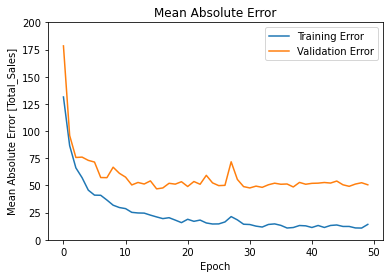

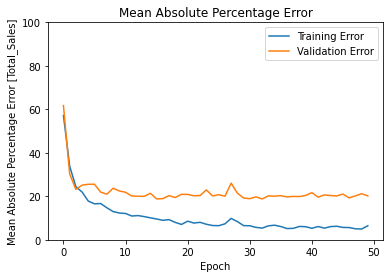

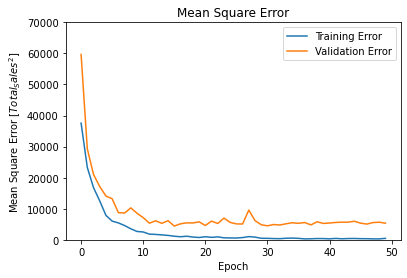

In [62]:
# Plotting KPI metrics
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
     
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Absolute Error [Total_Sales]')
    plt.plot(hist['epoch'], hist['mae'],label='Training Error')
    plt.plot(hist['epoch'], hist['val_mae'],label='Validation Error')
    plt.legend()
    plt.title('Mean Absolute Error')
    plt.ylim([0,200])
    
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Absolute Percentage Error [Total_Sales]')
    plt.plot(hist['epoch'], hist['mape'],label='Training Error')
    plt.plot(hist['epoch'], hist['val_mape'],label='Validation Error')
    plt.legend()
    plt.title('Mean Absolute Percentage Error')
    plt.ylim([0,100])
    
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$Total_Sales^2$]')
    plt.plot(hist['epoch'], hist['mse'],label='Training Error')
    plt.plot(hist['epoch'], hist['val_mse'],label='Validation Error')
    plt.legend()
    plt.title('Mean Square Error')
    plt.ylim([0,70000])
    

    
plot_history(history)

**The plots shows absolute error increasing for validation error. This is an example of overfitting.**

In [63]:
norm_test

,CTA2.Paid.BAT,Website_Visits.Paid.TCOM,CTA1.Organic.TCOM,CTA1.Paid.TCOM,CTA2.Organic.TCOM,CTA2.Paid.TCOM,Lead_Sales.Category_7,Lead_Sales.Category_5,Lead_Sales.Category_6,Lead_Sales.Category_4,...,Region 5,Region 6,Region 7,Region 8,Region 9,Week_of_Month_1,Week_of_Month_2,Week_of_Month_3,Week_of_Month_4,Week_of_Month_5
2020-10-04,0.113106,-1.092301,-0.860109,-0.708414,-0.702060,-0.560676,-1.172922,-0.358037,-0.723987,-0.280511,...,0,0,0,0,0,1,0,0,0,0
2020-10-04,-0.734345,-1.070692,-0.882747,-0.759614,-0.814423,-0.716689,-0.286732,0.547621,-0.723987,-0.280511,...,0,0,0,0,0,1,0,0,0,0
2020-10-04,-0.564854,-0.119077,-0.423376,-0.330563,0.004222,0.302596,-0.877525,-1.263694,-0.723987,-0.280511,...,0,0,0,0,0,1,0,0,0,0
2020-10-04,-0.903835,1.393582,0.612330,0.389301,-0.958890,-0.851900,1.781045,0.547621,-0.723987,-0.280511,...,0,0,0,0,0,1,0,0,0,0
2020-10-04,0.791067,0.369136,-0.155489,-0.058182,0.052377,0.177785,-0.582128,0.547621,0.231141,-0.280511,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-13,-0.734345,0.404351,0.840601,1.158317,3.952979,3.162833,-0.582128,-1.263694,-0.723987,-0.280511,...,1,0,0,0,0,0,1,0,0,0
2021-06-13,1.469028,0.559619,2.346053,0.456885,-0.694034,2.757199,-1.172922,-1.263694,-0.723987,-0.280511,...,0,1,0,0,0,0,1,0,0,0
2021-06-13,-0.903835,-0.832988,-0.369610,-0.590656,1.079696,-0.155042,0.304062,-0.810866,-0.723987,-0.280511,...,0,0,1,0,0,0,1,0,0,0
2021-06-13,-0.056384,0.305108,2.379068,0.251063,6.023669,3.953298,-0.286732,-0.810866,2.141397,-0.280511,...,0,0,0,1,0,0,1,0,0,0


**Final Predictions**

In [64]:
predictions = hypermodel.predict(norm_test).flatten()

In [65]:
# Reindexing for plot
predictions1 = pd.Series(predictions)

#testlabel1 = testlabel
#testlabel1.index = predictions1.index

In [66]:
test['Sales'] = hypermodel.predict(norm_test)

In [67]:
test

,CTA2.Paid.BAT,Website_Visits.Paid.TCOM,CTA1.Organic.TCOM,CTA1.Paid.TCOM,CTA2.Organic.TCOM,CTA2.Paid.TCOM,Lead_Sales.Category_7,Lead_Sales.Category_5,Lead_Sales.Category_6,Lead_Sales.Category_4,...,Region 6,Region 7,Region 8,Region 9,Week_of_Month_1,Week_of_Month_2,Week_of_Month_3,Week_of_Month_4,Week_of_Month_5,Sales
2020-10-04,6,971,512,399,83,70,0,2,0,0,...,0,0,0,0,1,0,0,0,0,82.631424
2020-10-04,1,998,488,349,69,55,3,4,0,0,...,0,0,0,0,1,0,0,0,0,69.974403
2020-10-04,2,2187,975,768,171,153,1,0,0,0,...,0,0,0,0,1,0,0,0,0,157.878220
2020-10-04,0,4077,2073,1471,51,42,10,4,0,0,...,0,0,0,0,1,0,0,0,0,628.237122
2020-10-04,10,2797,1259,1034,177,141,2,4,1,0,...,0,0,0,0,1,0,0,0,0,213.177567
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-13,1,2841,2315,2222,663,428,2,0,0,0,...,0,0,0,0,0,1,0,0,0,332.514893
2021-06-13,14,3035,3911,1537,84,389,0,0,0,0,...,1,0,0,0,0,1,0,0,0,243.261307
2021-06-13,0,1295,1032,514,305,109,5,1,0,0,...,0,1,0,0,0,1,0,0,0,195.938385
2021-06-13,5,2717,3946,1336,921,504,3,1,3,0,...,0,0,1,0,0,1,0,0,0,418.440308


In [68]:
cols = list(test.columns)

In [69]:
cols = [cols[-1]] + cols[:-1]

In [70]:
cols

['Sales',
 'CTA2.Paid.BAT',
 'Website_Visits.Paid.TCOM',
 'CTA1.Organic.TCOM',
 'CTA1.Paid.TCOM',
 'CTA2.Organic.TCOM',
 'CTA2.Paid.TCOM',
 'Lead_Sales.Category_7',
 'Lead_Sales.Category_5',
 'Lead_Sales.Category_6',
 'Lead_Sales.Category_4',
 'Lead_Sales.Category_9',
 'Lead_Sales.Category_7_lag2',
 'Lead_Sales.Category_5_lag1',
 'Lead_Sales.Category_5_lag3',
 'Lead_Sales.Category_4_lag2',
 'Lead_Sales.Category_4_lag3',
 'Lead_Sales.Category_4_lag4',
 'Lead_Sales.Category_9_lag1',
 'Lead_Sales.Category_9_lag2',
 'Impressions.Connected_TV.Display',
 'Qualified_Actions.Desktop.Display',
 'Qualified_Actions.Mobile.Display',
 'Qualified_Actions.NA.Search',
 'Qualified_Actions.NA.Social',
 'Impressions.Connected_TV.Video',
 'Impressions.Unknown_Platform.Video',
 'Qualified_Actions.Mobile.Video',
 'new_cases',
 'new_deaths',
 'people_fully_vaccinated',
 'SP_Open',
 'SP_Low',
 'SP_Close',
 'AF',
 'AH',
 'AL',
 'AR',
 'AW',
 'Region 1',
 'Region 10',
 'Region 11',
 'Region 12',
 'Region 2',
 '

In [71]:
test = test[cols]

In [72]:
test

,Sales,CTA2.Paid.BAT,Website_Visits.Paid.TCOM,CTA1.Organic.TCOM,CTA1.Paid.TCOM,CTA2.Organic.TCOM,CTA2.Paid.TCOM,Lead_Sales.Category_7,Lead_Sales.Category_5,Lead_Sales.Category_6,...,Region 5,Region 6,Region 7,Region 8,Region 9,Week_of_Month_1,Week_of_Month_2,Week_of_Month_3,Week_of_Month_4,Week_of_Month_5
2020-10-04,82.631424,6,971,512,399,83,70,0,2,0,...,0,0,0,0,0,1,0,0,0,0
2020-10-04,69.974403,1,998,488,349,69,55,3,4,0,...,0,0,0,0,0,1,0,0,0,0
2020-10-04,157.878220,2,2187,975,768,171,153,1,0,0,...,0,0,0,0,0,1,0,0,0,0
2020-10-04,628.237122,0,4077,2073,1471,51,42,10,4,0,...,0,0,0,0,0,1,0,0,0,0
2020-10-04,213.177567,10,2797,1259,1034,177,141,2,4,1,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-13,332.514893,1,2841,2315,2222,663,428,2,0,0,...,1,0,0,0,0,0,1,0,0,0
2021-06-13,243.261307,14,3035,3911,1537,84,389,0,0,0,...,0,1,0,0,0,0,1,0,0,0
2021-06-13,195.938385,0,1295,1032,514,305,109,5,1,0,...,0,0,1,0,0,0,1,0,0,0
2021-06-13,418.440308,5,2717,3946,1336,921,504,3,1,3,...,0,0,0,1,0,0,1,0,0,0


***Formatting Categorical Variables***

In [73]:
test.to_csv('Final_Test_Predictions_Alldata.csv')

In [74]:
formatting = pd.read_csv('Final_Test_Predictions_Alldata.csv', header=0)
formatting.head(20)
formatting=formatting.rename(columns = {'Unnamed: 0':'Week'})

In [75]:
def undummy(d):
    return d.dot(d.columns)

In [76]:
formatting = formatting.assign(Region=formatting.filter(regex='^Region').pipe(undummy))
formatting = formatting.assign(Week_of_Month=formatting.filter(regex='^Week_of_Month').pipe(undummy))
formatting = formatting.assign(Model=formatting.filter(regex='^A').pipe(undummy))

In [77]:
col_list = ['Week','Model','Region','Sales']

In [78]:
formatting = formatting[col_list]

In [79]:
formatting

,Week,Model,Region,Sales
0,2020-10-04,AF,Region 1,82.631424
1,2020-10-04,AF,Region 10,69.974400
2,2020-10-04,AF,Region 11,157.878220
3,2020-10-04,AF,Region 12,628.237100
4,2020-10-04,AF,Region 2,213.177570
...,...,...,...,...
2215,2021-06-13,AW,Region 5,332.514900
2216,2021-06-13,AW,Region 6,243.261300
2217,2021-06-13,AW,Region 7,195.938390
2218,2021-06-13,AW,Region 8,418.440300


In [80]:
formatting.to_csv('predictions_alldata_formatted.csv')